In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [8]:
df_gen_uniq = pd.read_csv('dados/generos_uniq.csv',sep=';')
df_gen_uniq.head()

,titulo,generos
0,Good Omens,Fantasia
1,The Office,Comédia
2,Friends,Comédia
3,The Big Bang Theory,Comédia
4,How I Met Your Mother,Comédia


In [31]:
df_gen = pd.read_csv('dados/generos.csv',sep=';')
df_gen.head()

,titulo,generos
0,Good Omens,"Comedia,Fantasia"
1,The Office,Comedia
2,Friends,"Comedia,Romance"
3,The Big Bang Theory,"Comedia,Romance"
4,How I Met Your Mother,"Comedia,Romance"


In [4]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))

pathlib.Path(f'img_data').mkdir(parents=True, exist_ok=True)
for filename in os.listdir('dados/audio'):
    songname = f'dados/audio/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'img_data/{filename[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 576x576 with 0 Axes>

In [5]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [33]:
#Múltiplos genêros por tema
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
for filename in os.listdir('dados/audio'):
    songname = f'dados/audio/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    for g in df_gen[df_gen['titulo'] == f'{filename[:-4]}']['generos'].values[0].split(','):
        to_append = f'{filename};{np.mean(chroma_stft)};{np.mean(rmse)};{np.mean(spec_cent)};{np.mean(spec_bw)};{np.mean(rolloff)};{np.mean(zcr)}'    
        for e in mfcc:
            to_append += f';{np.mean(e)}'
    
        to_append += f';{g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split(';'))

In [10]:
#Somente um genêro por música
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
for filename in os.listdir('dados/audio'):
    songname = f'dados/audio/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename};{np.mean(chroma_stft)};{np.mean(rmse)};{np.mean(spec_cent)};{np.mean(spec_bw)};{np.mean(rolloff)};{np.mean(zcr)}'    
    for e in mfcc:
        to_append += f';{np.mean(e)}'
    g = df_gen_uniq[df_gen_uniq['titulo'] == f'{filename[:-4]}']['generos'].values[0]
    to_append += f';{g}'
    file = open('dataset.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split(';'))

In [14]:
data = pd.read_csv('dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## ANN

In [16]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
1/1 [==============================] - 1s 526ms/step - loss: 2.3361 - accuracy: 0.1250
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2239 - accuracy: 0.3250
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1330 - accuracy: 0.4000
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0536 - accuracy: 0.4500
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 1.9812 - accuracy: 0.5250
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9124 - accuracy: 0.6250
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8430 - accuracy: 0.6500
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7737 - accuracy: 0.6750
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7052 - accuracy: 0.6750
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6358 - accuracy: 0.6500
Epoch 11/100
1/1 [=========

1/1 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 87/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 90/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 91/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 92/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 93/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 94/100
1/1 [===============

## KNN

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
cat = pd.Categorical(data['label'])
scaler = preprocessing.StandardScaler()
Z_train = scaler.fit_transform(X_train)

model = KNeighborsClassifier()
model = model.fit(Z_train, y_train)

Z_test = scaler.transform(X_test)
model.predict(Z_test)


array([0, 0, 2, 4, 4, 6, 4, 4, 1, 0])

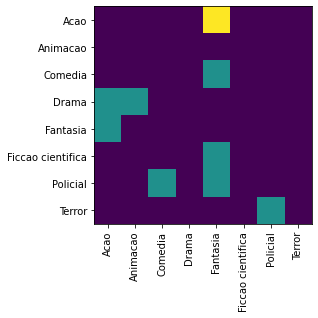

In [26]:
plt.imshow(confusion_matrix(y_test, model.predict(X_test)))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], cat.categories, rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], cat.categories);

## LV

[1 1 1 6 6 3 6 3 3 6]


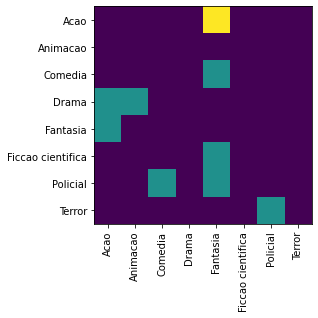

In [28]:
from sklearn.linear_model import LogisticRegressionCV
model_LR = LogisticRegressionCV()
model_LR = model_LR.fit(X_train, y_train)
print(model_LR.predict(X_test))

plt.imshow(confusion_matrix(y_test, model.predict(X_test)))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], cat.categories, rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], cat.categories);

## SVC

[6 6 6 6 4 6 6 3 3 4]


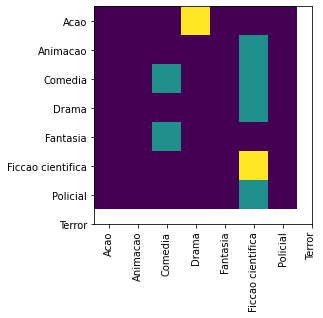

In [29]:
from sklearn.svm import SVC
model_svc = SVC()
model_svc = model_svc.fit(X_train, y_train)
print(model_svc.predict(X_test))

plt.imshow(confusion_matrix(y_test, model_svc.predict(X_test)))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], cat.categories, rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], cat.categories);

In [19]:
np.unique(data['label'].values)

array(['Acao', 'Animacao', 'Comedia', 'Drama', 'Fantasia',
       'Ficcao cientifica', 'Policial', 'Terror'], dtype=object)